# Library

In [1]:
import torch
import numpy as np
from numpy import sin,cos
import matplotlib.pyplot as plt
from scipy.optimize import minimize


from Agraph import binary_node,unary_node,Tree
from helper import _is,sampling
from GenAgraph import GenOperator,organizeTree
from evalAgraph import evaluateAgraph
from LocalOpt import local_optimizer
from GenPreorder import GenPreorder
from PreorderToTree import preorder_to_tree

#  Generate dataset

In [2]:
n = 20

ele = ele = np.linspace(1e-9,1,n)
x_0 = np.kron(ele,np.ones(len(ele)))
x_1 = np.kron(np.ones(len(ele)),ele)

if torch.cuda.is_available():
    print("Good to go!")
    device = "cude"
else:
    device = 'cpu'

Good to go!


In [3]:
def Decode(span,complexity):
    OpTree = Tree()
    op,Node = sampling(span=span)
    while op>=9:
        op,Node = sampling(span=span)
        
    OpTree.root = Node
    nodes = [op]

    GenOperator(OpTree,complexity,OpTree.root,nodes,span)
    organizeTree(OpTree)

    preorder = GenPreorder(OpTree)
    root = OpTree.root
    result = evaluateAgraph(root,mode='numeric',x_0=x_0,x_1=x_1)

    exp = evaluateAgraph(root,mode='symbolic')
    num_c = exp.count('c_')
    
    constants,loss = None,None
    if num_c > 0:
        _,loss = local_optimizer(OpTree,num_c,result, x_0, x_1)
        
    return preorder,result,loss

def GenData(span_array,complexity,maxiter):
    maxLen = -np.inf
    preorder_tensor = []
    result_tensor = []
    for span in span_array:
        cnt = 0
        while cnt<maxiter:
            preorder,result,loss = Decode(span,complexity)
            if np.any(np.isnan(result))!=True and np.any(np.isinf(result))!=True:
                maxLen = max(len(preorder),maxLen)
                if loss==None:
                    cnt+=1
                    preorder_tensor.append(preorder)
                    result_tensor.append(result)
                if loss !=None:
                    if loss>1e-5:
                        pass
                    else:
                        cnt+=1
                        preorder_tensor.append(preorder)
                        result_tensor.append(result)
                
    for i,preorder in enumerate(preorder_tensor):
        if len(preorder)<maxLen:
            delta = maxLen - len(preorder)
            preorder_tensor[i] = preorder + [0]*delta

   
    preorder_tensor = np.array(preorder_tensor)
    result_tensor = np.array(result_tensor)
    
    n = preorder_tensor.shape[0]
    shuffle_ind = np.arange(0,n)
    np.random.shuffle(shuffle_ind)
    
    preorder_tensor = preorder_tensor[shuffle_ind]
    result_tensor = result_tensor[shuffle_ind]
    
    return preorder_tensor,result_tensor

In [4]:
span_array = [1,2,3]
complexity = 11
maxiter = 500
preorder_tensor,result_tensor = GenData(span_array,complexity,maxiter)    

C:\Users\hongs\Downloads\Deep_Symbolic_Regression\evalAgraph.py:64: RuntimeWarning: divide by zero encountered in true_divide
  return left_sum / right_sum
C:\Users\hongs\Downloads\Deep_Symbolic_Regression\evalAgraph.py:70: RuntimeWarning: invalid value encountered in sin
  return np.sin(child_sum)
C:\Users\hongs\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\hongs\Downloads\Deep_Symbolic_Regression\evalAgraph.py:76: RuntimeWarning: invalid value encountered in cos
  return np.cos(child_sum)
C:\Users\hongs\Downloads\Deep_Symbolic_Regression\evalAgraph.py:64: RuntimeWarning: invalid value encountered in true_divide
  return left_sum / right_sum
C:\Users\hongs\Downloads\Deep_Symbolic_Regression\LocalOpt.py:10: RuntimeWarning: invalid value encountered in subtract
  objfn = lambda x: np.sqrt(np.mean((evaluateAgraph(root,mode,constants=x, x_0=x_0, x_1=x_1) - result)**2))


In [5]:
num_train = (3*maxiter)//2

data_dict = {}

data_dict['idx_to_op'] = ['<NULL>','<START>','<END>','+','-','*','/','sin','cos','c','x_0','x_1']
data_dict['opt_to_idx'] = {'<NULL>':0,'<START>':1,'<END>':2,'+':3,'-':4,'*':5,'/':6,'sin':7,'cos':8,'c':9,'x_0':10,'x_1':11}

data_dict['train_preorder'] = torch.from_numpy(preorder_tensor[:(3*maxiter)//2,:]).to('cuda')
data_dict['val_preorder'] = torch.from_numpy(preorder_tensor[(3*maxiter)//2:,:]).to('cuda')

data_dict['train_result'] = torch.from_numpy(result_tensor[:(3*maxiter)//2,:]).to('cuda')
data_dict['val_result'] = torch.from_numpy(result_tensor[(3*maxiter)//2:,:]).to('cuda')

# Look at the data

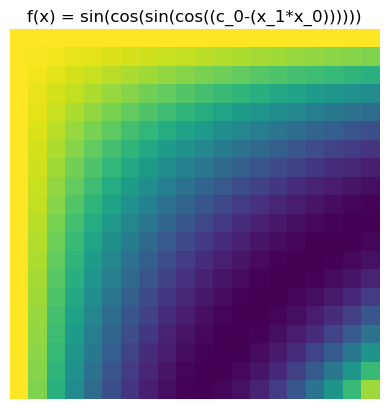

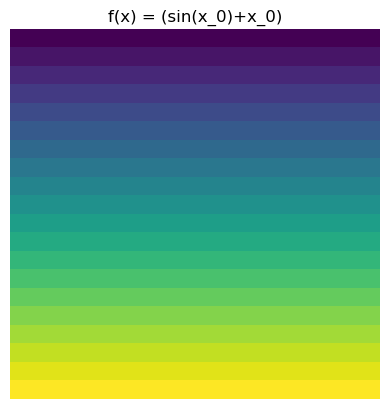

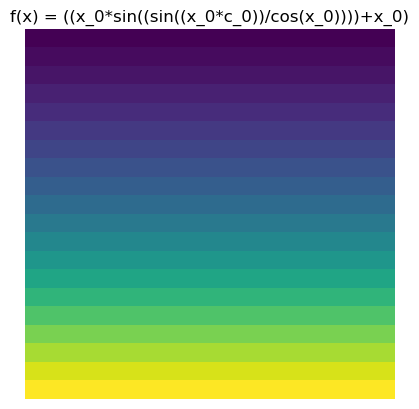

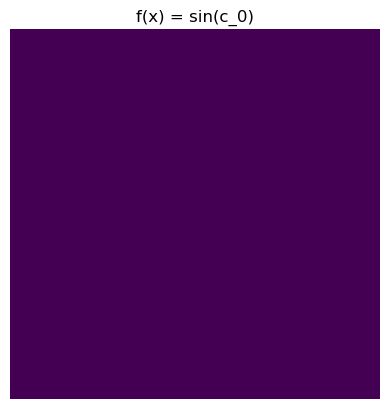

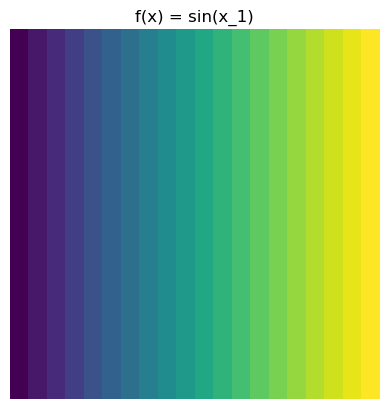

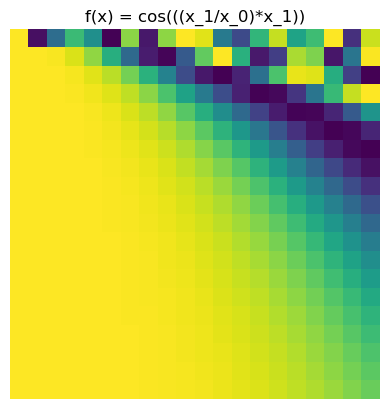

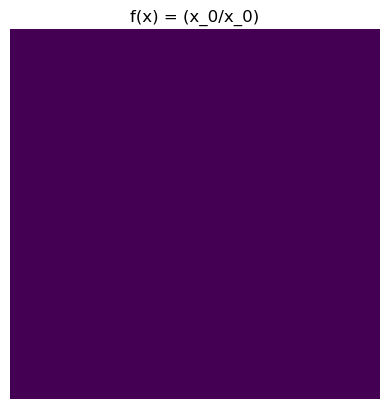

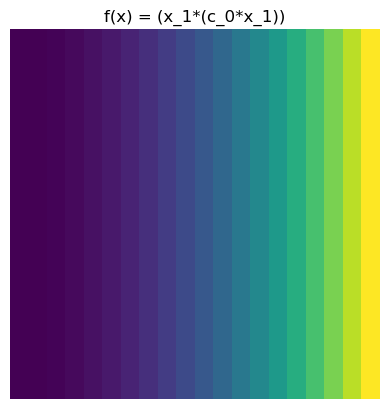

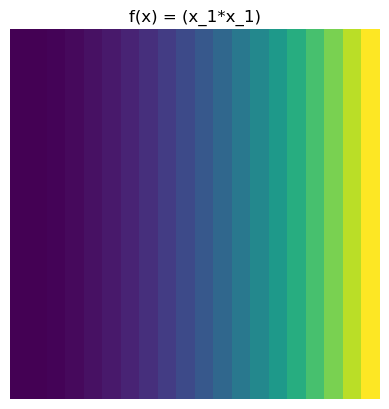

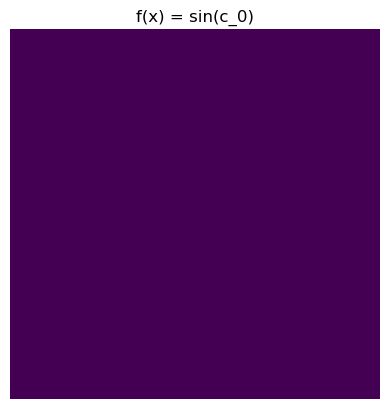

In [11]:
batch_size = 10
sample_idx = torch.randint(0, num_train, (batch_size,))
sample_pre_order = preorder_tensor[sample_idx]
sample_result = result_tensor[sample_idx]


for i,pre_order in enumerate(sample_pre_order):
    result = sample_result[i]
    result = result.reshape((n,n))
    TestTree = preorder_to_tree(pre_order)
    root = TestTree.root
    
    plt.imshow(result)
    plt.title('f(x) = {}'.format(evaluateAgraph(root,mode='symbolic')),fontsize = 12)
    plt.axis('off')
    plt.show()